<a href="https://colab.research.google.com/github/nisal435/Automatic-Summarization-using-Deep-Learning/blob/main/GROUP_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Dataset loading / prep

def load_images_raw(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, rows * cols)
        return data

def load_labels_raw(path):
    with open(path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

def prepare_mnist_subset(data_dir="mnist_data", subset_size=1000, rng_seed=42):
    paths = {
        'train_images': os.path.join(data_dir, 'train-images.idx3-ubyte'),
        'train_labels': os.path.join(data_dir, 'train-labels.idx1-ubyte'),
        'test_images':  os.path.join(data_dir, 't10k-images.idx3-ubyte'),
        'test_labels':  os.path.join(data_dir, 't10k-labels.idx1-ubyte'),
    }
    urls = {
        'train_images': 'https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz',
        'train_labels': 'https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz',
        'test_images': 'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz',
        'test_labels': 'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz',
    }

    os.makedirs(data_dir, exist_ok=True)
    # download & extract if missing
    for key, url in urls.items():
        gzpath = os.path.join(data_dir, os.path.basename(url))
        outpath = paths[key]
        if not os.path.exists(outpath):
            print(f"Downloading {url} ...")
            urllib.request.urlretrieve(url, gzpath)
            print(f"Extracting {gzpath} ...")
            with gzip.open(gzpath, 'rb') as f_in, open(outpath, 'wb') as f_out:
                f_out.writelines(f_in)
            os.remove(gzpath)
            print("done.")
        else:
            print(f"{outpath} exists, skipping.")

    X_train_all = load_images_raw(paths['train_images']).astype(np.float32) / 255.0
    y_train_all = load_labels_raw(paths['train_labels']).astype(np.int64)

    rng = np.random.default_rng(rng_seed)
    idx = rng.permutation(len(X_train_all))[:subset_size]
    X = X_train_all[idx]
    y = y_train_all[idx]
    return X, y, paths


In [3]:

# Utilities

def to_one_hot(y, num_classes=10):
    return np.eye(num_classes, dtype=np.float32)[y]

def iterate_batches(X_arr, Y_arr, batch_size=64, shuffle=True):
    n_samples = X_arr.shape[0]
    idx = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(idx)
    for start in range(0, n_samples, batch_size):
        batch_idx = idx[start:start+batch_size]
        yield X_arr[batch_idx], Y_arr[batch_idx]

In [4]:
# Layers & Activations

class Linear:
    def __init__(self, in_features, out_features, weight_init_fn=None, bias=True):
        # W shape: (out_features, in_features)
        if weight_init_fn is None:
            self.W = (np.random.randn(out_features, in_features).astype(np.float32) * 0.01)
        else:
            self.W = weight_init_fn((out_features, in_features)).astype(np.float32)
        self.b = np.zeros((out_features,), dtype=np.float32) if bias else None

        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b) if bias else None
        self._cache = {}

    def forward(self, X):
        # X: (batch, in_features)
        self._cache['X'] = X
        out = X.dot(self.W.T)
        if self.b is not None:
            out = out + self.b[None, :]
        return out

    def backward(self, d_out):
        X = self._cache['X']
        batch_size = X.shape[0]
        # dW: (out, in)
        self.dW = d_out.T.dot(X) / batch_size
        if self.b is not None:
            self.db = np.mean(d_out, axis=0)
        # dX: (batch, in) = d_out @ W
        dX = d_out.dot(self.W)
        return dX

    def zero_grad(self):
        self.dW[...] = 0.0
        if self.b is not None:
            self.db[...] = 0.0

    def params_and_grads(self):
        if self.b is not None:
            return [(self.W, self.dW), (self.b, self.db)]
        else:
            return [(self.W, self.dW)]

class ReLU:
    def __init__(self):
        self._mask = None
    def forward(self, X):
        self._mask = (X > 0).astype(np.float32)
        return X * self._mask
    def backward(self, d_out):
        return d_out * self._mask

class Sigmoid:
    def __init__(self):
        self._out = None
    def forward(self, X):
        out = 1.0 / (1.0 + np.exp(-X))
        self._out = out
        return out
    def backward(self, d_out):
        s = self._out
        return d_out * (s * (1.0 - s))

class GELU:
    def __init__(self):
        self._x = None
        self._tanh_u = None
        self._a = 0.044715
        self._c = np.sqrt(2.0 / np.pi)
    def forward(self, X):
        self._x = X
        u = self._c * (X + self._a * np.power(X, 3))
        t = np.tanh(u)
        self._tanh_u = t
        return 0.5 * X * (1.0 + t)
    def backward(self, d_out):
        x = self._x
        t = self._tanh_u
        a = self._a
        c = self._c
        du_dx = c * (1.0 + 3.0 * a * x * x)
        dt_du = 1.0 - t * t
        dt_dx = dt_du * du_dx
        grad = 0.5 * (1.0 + t) + 0.5 * x * dt_dx
        return d_out * grad


In [5]:
# Initializers

def xavier_init(shape):
    fan_in, fan_out = shape[1], shape[0]
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=shape).astype(np.float32)

def kaiming_init(shape):
    fan_in = shape[1]
    std = np.sqrt(2.0 / fan_in)
    return np.random.randn(*shape).astype(np.float32) * std

In [6]:
# Loss (softmax + CE)

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def cross_entropy_loss(logits, y_true):
    probs = softmax(logits)
    batch_size = logits.shape[0]
    loss = -np.sum(y_true * np.log(probs + 1e-12)) / batch_size
    return loss, probs

def cross_entropy_backward(probs, y_true):
    batch_size = probs.shape[0]
    return (probs - y_true) / batch_size

In [7]:
# MLPs

class MLP:
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10,
                 hidden_activation='relu', weight_init='xavier'):
        if weight_init.lower() == 'xavier':
            init_fn = xavier_init
        elif weight_init.lower() == 'kaiming':
            init_fn = kaiming_init
        else:
            init_fn = None

        self.fc1 = Linear(input_dim, hidden_dim, weight_init_fn=init_fn)
        self.fc2 = Linear(hidden_dim, output_dim, weight_init_fn=init_fn)

        if hidden_activation.lower() == 'relu':
            self.activation = ReLU()
        elif hidden_activation.lower() == 'sigmoid':
            self.activation = Sigmoid()
        elif hidden_activation.lower() == 'gelu':
            self.activation = GELU()
        else:
            raise ValueError("Unknown activation")

    def forward(self, X):
        self.h1 = self.fc1.forward(X)
        self.a1 = self.activation.forward(self.h1)
        self.logits = self.fc2.forward(self.a1)
        return self.logits

    def backward(self, dL_dlogits):
        d_a1 = self.fc2.backward(dL_dlogits)
        d_h1 = self.activation.backward(d_a1)
        _ = self.fc1.backward(d_h1)

    def zero_grad(self):
        self.fc1.zero_grad()
        self.fc2.zero_grad()

    def params_and_grads(self):
        return self.fc1.params_and_grads() + self.fc2.params_and_grads()

class MLP_TwoHidden:
    def __init__(self, input_dim=784, hidden_dims=(128,128), output_dim=10,
                 hidden_activations=('relu','relu'), weight_init='xavier'):
        assert len(hidden_dims) == 2
        assert len(hidden_activations) == 2

        if weight_init.lower() == 'xavier':
            init_fn = xavier_init
        elif weight_init.lower() == 'kaiming':
            init_fn = kaiming_init
        else:
            init_fn = None

        self.fc1 = Linear(input_dim, hidden_dims[0], weight_init_fn=init_fn)
        self.fc2 = Linear(hidden_dims[0], hidden_dims[1], weight_init_fn=init_fn)
        self.fc3 = Linear(hidden_dims[1], output_dim, weight_init_fn=init_fn)

        def make_act(name):
            if name.lower() == 'relu':
                return ReLU()
            elif name.lower() == 'sigmoid':
                return Sigmoid()
            elif name.lower() == 'gelu':
                return GELU()
            else:
                raise ValueError("Unknown activation")

        self.act1 = make_act(hidden_activations[0])
        self.act2 = make_act(hidden_activations[1])

    def forward(self, X):
        h1 = self.fc1.forward(X)
        a1 = self.act1.forward(h1)
        h2 = self.fc2.forward(a1)
        a2 = self.act2.forward(h2)
        logits = self.fc3.forward(a2)
        # store last intermediate for possible debugging (not needed)
        return logits

    def backward(self, dL_dlogits):
        d_a2 = self.fc3.backward(dL_dlogits)
        d_h2 = self.act2.backward(d_a2)
        d_a1 = self.fc2.backward(d_h2)
        d_h1 = self.act1.backward(d_a1)
        _ = self.fc1.backward(d_h1)

    def zero_grad(self):
        self.fc1.zero_grad()
        self.fc2.zero_grad()
        self.fc3.zero_grad()

    def params_and_grads(self):
        return self.fc1.params_and_grads() + self.fc2.params_and_grads() + self.fc3.params_and_grads()


In [8]:
# Optimizers

class VanillaSGD_NP:
    def __init__(self, params, lr=0.1):
        # params: list of dicts with keys 'w' and 'dw'
        self.params = params
        self.lr = lr

    def step(self):
        for p in self.params:
            p['w'] -= self.lr * p['dw']

    def zero_grad(self):
        for p in self.params:
            p['dw'].fill(0.0)

class SGDMomentum_NP:
    def __init__(self, params, lr=0.1, momentum=0.9):
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.vel = [np.zeros_like(p['w']) for p in self.params]

    def step(self):
        for i, p in enumerate(self.params):
            self.vel[i] = self.momentum * self.vel[i] - self.lr * p['dw']
            p['w'] += self.vel[i]

    def zero_grad(self):
        for p in self.params:
            p['dw'].fill(0.0)

In [9]:
# Train / Eval

def evaluate_accuracy(mlp, X_arr, y_arr, batch_size=256):
    n = X_arr.shape[0]
    preds = []
    for i in range(0, n, batch_size):
        xb = X_arr[i:i+batch_size]
        logits = mlp.forward(xb)
        probs = softmax(logits)
        preds.append(np.argmax(probs, axis=1))
    preds = np.concatenate(preds, axis=0)
    return (preds == y_arr).mean()

def train_mlp(mlp, optimizer_class, X_train, y_train_oh,
              X_val=None, y_val=None,
              epochs=20, batch_size=64, lr=0.1, momentum=0.9,
              verbose=True):
    params = [{'w': p, 'dw': g} for p,g in mlp.params_and_grads()]
    # instantiate optimizer
    try:
        opt = optimizer_class(params, lr=lr, momentum=momentum)
    except TypeError:
        opt = optimizer_class(params, lr=lr)

    loss_history = []
    val_acc_history = []

    for ep in range(1, epochs + 1):
        epoch_losses = []
        # shuffle inside iterate_batches
        for Xb, Yb_oh in iterate_batches(X_train, y_train_oh, batch_size=batch_size, shuffle=True):
            logits = mlp.forward(Xb)
            loss, probs = cross_entropy_loss(logits, Yb_oh)
            epoch_losses.append(loss)

            grad_logits = cross_entropy_backward(probs, Yb_oh)
            mlp.backward(grad_logits)

            opt.step()
            # zero grads kept in layer objects; but params list uses references to numpy arrays
            try:
                opt.zero_grad()
            except:
                pass
            mlp.zero_grad()

        mean_loss = float(np.mean(epoch_losses))
        loss_history.append(mean_loss)

        if X_val is not None and y_val is not None:
            val_acc = evaluate_accuracy(mlp, X_val, y_val)
            val_acc_history.append(val_acc)
            if verbose:
                print(f"Epoch {ep}/{epochs}  loss={mean_loss:.4f}  val_acc={val_acc:.4f}")
        else:
            val_acc_history.append(None)
            if verbose:
                print(f"Epoch {ep}/{epochs}  loss={mean_loss:.4f}")

    return {
        'loss_history': loss_history,
        'val_acc_history': val_acc_history,
        'final_model': mlp
    }

In [10]:
# Activation experiments

def run_activation_experiments(X_train, y_train_oh, X_val, y_val, X_test, y_test,
                               activations=('sigmoid','relu','gelu'),
                               hidden_dims=(128,128),
                               epochs=20,
                               lr=0.1,
                               momentum=0.9,
                               batch_size=64,
                               optimizer_class=SGDMomentum_NP,
                               verbose=True):
    results = {}
    for act in activations:
        print("\n" + "="*40)
        print(f"Activation: {act}")
        # choose initializer: xavier for sigmoid, kaiming otherwise
        winit = 'xavier' if act.lower() == 'sigmoid' else 'kaiming'
        mlp = MLP_TwoHidden(input_dim=784,
                            hidden_dims=hidden_dims,
                            output_dim=10,
                            hidden_activations=(act, act),
                            weight_init=winit)
        res = train_mlp(mlp, optimizer_class, X_train, y_train_oh,
                        X_val, y_val,
                        epochs=epochs, batch_size=batch_size,
                        lr=lr, momentum=momentum, verbose=verbose)
        test_acc = evaluate_accuracy(res['final_model'], X_test, y_test)
        print(f"--> Final test accuracy for {act}: {test_acc:.4f}")
        res['test_acc'] = test_acc
        res['activation'] = act
        res['weight_init'] = winit
        results[act] = res
    return results

def plot_loss_curves(results, title="Training Loss by Activation"):
    plt.figure(figsize=(8,5))
    for act, res in results.items():
        plt.plot(res['loss_history'], label=f"{act} (init={res['weight_init']})")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

In [11]:
# Combinations (initializer + optimizer)

def run_init_optimizer_combinations(X_train, y_train_oh, X_val, y_val,
                                    hidden_dim=128,
                                    epochs=10, lr=0.1, momentum=0.9,
                                    batch_size=64):
    combos = [
        ('Xavier + Vanilla SGD', 'xavier', VanillaSGD_NP),
        ('Xavier + SGD Momentum', 'xavier', SGDMomentum_NP),
        ('Kaiming + Vanilla SGD', 'kaiming', VanillaSGD_NP),
        ('Kaiming + SGD Momentum', 'kaiming', SGDMomentum_NP)
    ]
    all_loss_histories = {}
    combo_results = {}

    for combo_name, init_scheme, optimizer_class in combos:
        print("\n" + "#"*40)
        print(f"Training combination: {combo_name}")
        mlp = MLP(input_dim=784, hidden_dim=hidden_dim, output_dim=10,
                  hidden_activation='relu' if init_scheme=='kaiming' else 'sigmoid',
                  weight_init=init_scheme)
        res = train_mlp(mlp, optimizer_class, X_train, y_train_oh,
                        X_val, y_val, epochs=epochs, batch_size=batch_size,
                        lr=lr, momentum=momentum, verbose=True)
        all_loss_histories[combo_name] = res['loss_history']
        combo_results[combo_name] = res
        final_val = res['val_acc_history'][-1] if len(res['val_acc_history'])>0 else None
        print(f"Finished {combo_name}: last loss={res['loss_history'][-1]:.4f}  last val acc={final_val}")
    return all_loss_histories, combo_results

def plot_combination_losses(all_loss_histories):
    plt.figure(figsize=(10,6))
    for combo_name, loss_hist in all_loss_histories.items():
        plt.plot(loss_hist, label=combo_name)
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Curves for Initializer + Optimizer Combinations")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


Extracting mnist_data/train-images-idx3-ubyte.gz ...
done.
Extracting mnist_data/train-labels-idx1-ubyte.gz ...
done.
Extracting mnist_data/t10k-images-idx3-ubyte.gz ...
done.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz ...
done.
X shape: (1000, 784) y shape: (1000,)
Split sizes (train/val/test): 800 100 100
Label counts (train): [83 83 74 92 86 67 80 82 87 66]


########################################
Training combination: Xavier + Vanilla SGD
Epoch 1/10  loss=2.3592  val_acc=0.0800
Epoch 2/10  loss=2.3550  val_acc=0.0800
Epoch 3/10  loss=2.3536  val_acc=0.0800
Epoch 4/10  loss=2.3576  val_acc=0.0800
Epoch 5/10  loss=2.3601  val_acc=0.0800
Epoch 6/10  loss=2.3562  val_acc=0.0800
Epoch 7/10  loss=2.3569  val_acc=0.0800
Epoch 8/10  loss=2.3517  val_acc=0.0800
Epoch 9/10  loss=2.3573  val_acc=0.0800
Epoch 10/10  loss=2.3567  val_acc=0.0800
Finished Xavier + Vanilla SGD: last loss=2.3567  last val acc=0.08

########################################
Training combination: Xavier + SGD M

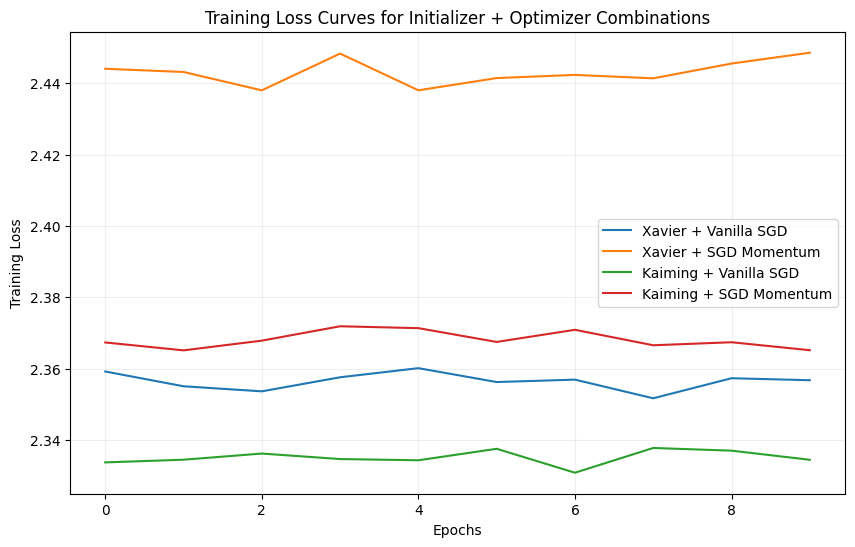


Summary for initializer+optimizer combos:
Xavier + Vanilla SGD: last loss=2.3567  last val acc=0.0800
Xavier + SGD Momentum: last loss=2.4486  last val acc=0.0900
Kaiming + Vanilla SGD: last loss=2.3344  last val acc=0.0700
Kaiming + SGD Momentum: last loss=2.3652  last val acc=0.1200

Activation: sigmoid
Epoch 1/15  loss=2.4391  val_acc=0.0600
Epoch 2/15  loss=2.4444  val_acc=0.0600
Epoch 3/15  loss=2.4376  val_acc=0.0600
Epoch 4/15  loss=2.4387  val_acc=0.0600
Epoch 5/15  loss=2.4400  val_acc=0.0600
Epoch 6/15  loss=2.4422  val_acc=0.0600
Epoch 7/15  loss=2.4374  val_acc=0.0600
Epoch 8/15  loss=2.4351  val_acc=0.0600
Epoch 9/15  loss=2.4392  val_acc=0.0600
Epoch 10/15  loss=2.4442  val_acc=0.0600
Epoch 11/15  loss=2.4360  val_acc=0.0600
Epoch 12/15  loss=2.4380  val_acc=0.0600
Epoch 13/15  loss=2.4383  val_acc=0.0600
Epoch 14/15  loss=2.4407  val_acc=0.0600
Epoch 15/15  loss=2.4368  val_acc=0.0600
--> Final test accuracy for sigmoid: 0.1100

Activation: relu
Epoch 1/15  loss=2.4968 

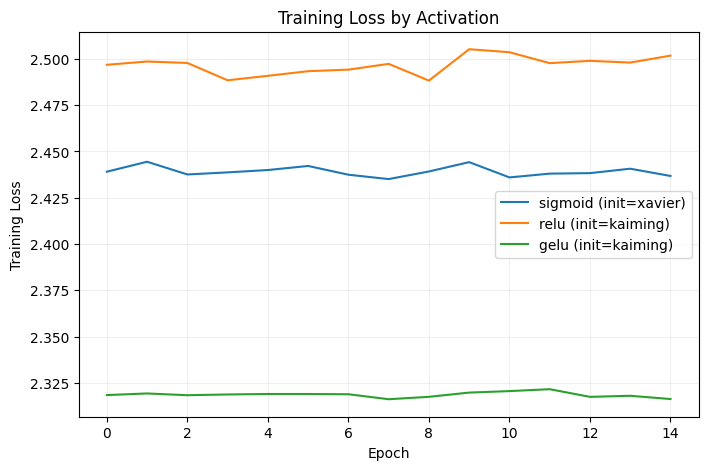


Activation experiment summary:
sigmoid | init=xavier | final test acc=0.1100 | last-val-acc=0.0600 | last-loss=2.4368
relu   | init=kaiming | final test acc=0.0500 | last-val-acc=0.1100 | last-loss=2.5017
gelu   | init=kaiming | final test acc=0.1000 | last-val-acc=0.1700 | last-loss=2.3164


In [12]:
# Main: prepare data, run experiments

if __name__ == "__main__":
    # Prepare data (1k subset)
    X, y, _ = prepare_mnist_subset(data_dir="mnist_data", subset_size=1000, rng_seed=42)
    print("X shape:", X.shape, "y shape:", y.shape)
    # split 80/10/10 deterministically
    rng = np.random.default_rng(123)
    n = X.shape[0]
    perm = rng.permutation(n)
    n_train = int(n * 0.8)
    n_val = int(n * 0.1)
    n_test = n - n_train - n_val
    train_idx = perm[:n_train]
    val_idx = perm[n_train:n_train + n_val]
    test_idx = perm[n_train + n_val:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    y_train_oh = to_one_hot(y_train)
    y_val_oh   = to_one_hot(y_val)
    y_test_oh  = to_one_hot(y_test)

    print("Split sizes (train/val/test):", X_train.shape[0], X_val.shape[0], X_test.shape[0])
    print("Label counts (train):", np.bincount(y_train))
    print()

    # Run initializer+optimizer combinations (Task 1)
    all_loss_histories, combo_results = run_init_optimizer_combinations(
        X_train, y_train_oh, X_val, y_val,
        hidden_dim=128, epochs=10, lr=0.1, momentum=0.9, batch_size=64
    )
    plot_combination_losses(all_loss_histories)

    # Evaluate and print final val accs
    print("\nSummary for initializer+optimizer combos:")
    for name, res in combo_results.items():
        val_acc = res['val_acc_history'][-1] if res['val_acc_history'][-1] is not None else float('nan')
        print(f"{name}: last loss={res['loss_history'][-1]:.4f}  last val acc={val_acc:.4f}")

    # Run activation experiments (Task 2)
    results = run_activation_experiments(X_train, y_train_oh, X_val, y_val, X_test, y_test,
                                        activations=('sigmoid','relu','gelu'),
                                        hidden_dims=(128,128),
                                        epochs=15, lr=0.1, momentum=0.9, batch_size=64,
                                        optimizer_class=SGDMomentum_NP,
                                        verbose=True)
    plot_loss_curves(results)

    print("\nActivation experiment summary:")
    for act, r in results.items():
        print(f"{act:6s} | init={r['weight_init']:6s} | final test acc={r['test_acc']:.4f} | last-val-acc={(r['val_acc_history'][-1] if r['val_acc_history'][-1] is not None else float('nan')):.4f} | last-loss={r['loss_history'][-1]:.4f}")

***One-paragraph summary***

From the training curves, Kaiming initialization with SGD Momentum converged fastest in terms of validation accuracy, reaching a final val_acc of 0.12, compared to other combinations. Although its training loss started slightly higher than Kaiming + Vanilla SGD, the momentum term accelerated convergence by smoothing oscillations and allowing the network to traverse shallow valleys in the loss landscape more efficiently. Xavier-based combinations, particularly Vanilla SGD, converged slower and to lower accuracy, likely due to the smaller initial weights limiting gradient magnitudes, while GELU activations (with Kaiming) generally helped preserve gradient flow, further supporting faster convergence.